## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from lane_detector import LaneDetector
from importlib import reload
%matplotlib qt
%matplotlib inline
%load_ext autoreload
%autoreload 2

Imageio: 'ffmpeg.linux64' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg.linux64 (27.2 MB)
Downloading: 8192/28549024 bytes (0.0450560/28549024 bytes (1.61196032/28549024 bytes (4.2%2064384/28549024 bytes (7.2%3031040/28549024 bytes (10.63907584/28549024 bytes (13.74997120/28549024 bytes (17.56111232/28549024 bytes (21.47208960/28549024 bytes (25.38192000/28549024 bytes (28.79306112/28549024 bytes (32.610346496/28549024 bytes (36.2%11436032/28549024 bytes (40.1%12492800/28549024 bytes (43.8%13582336/28549024 bytes (47.6%14630912/28549024 bytes (51.2%15794176/28549024 bytes (55.3%16973824/28549024 bytes (59.5%18120704/28549024 bytes (63.5%19234816/28549024 bytes (67.4%20152320/28549024 bytes (70.6%21315584/28549024 bytes (74.7%22380544/28549024 bytes (78.4%23396352/28549024 bytes (82.0%24444928/28549024 bytes (85.6%25624576/28549024 bytes (89.8%26648576/28549024 bytes (93.3%27754496/28549024 b

## Initialize and calibrate the LaneDetector

In [5]:
lane_detector = LaneDetector()

# Calibrate the lane detector
images = glob.glob('./camera_cal/calibration*.jpg')
lane_detector.calibrate(images)

## Verify the calibration visually by viewing the checkerboard image.

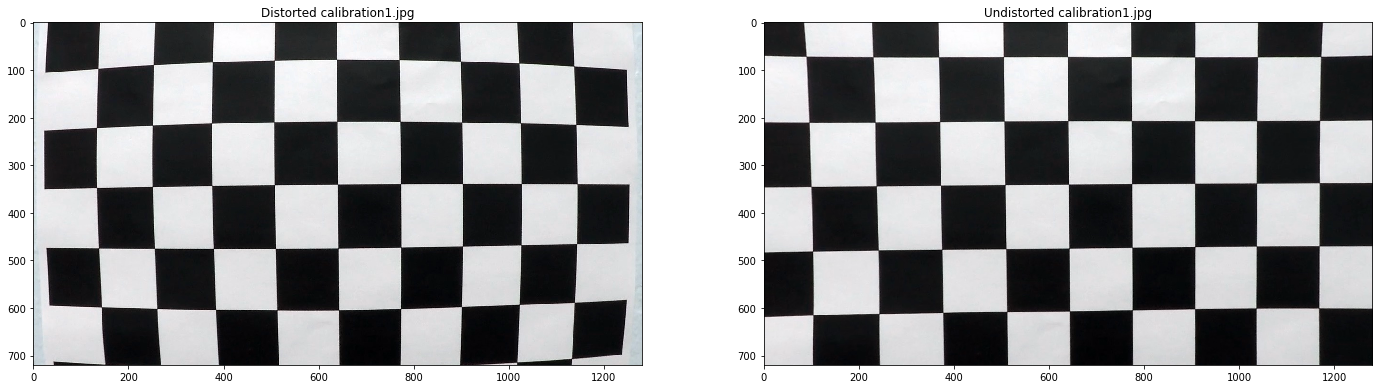

In [7]:
dist_img = cv2.imread('./camera_cal/calibration1.jpg')
undist = lane_detector.undistort(dist_img)

plt.figure(figsize=(24,9))
plt.subplot(1, 2, 1)

plt.title('Distorted calibration1.jpg')
plt.imshow(dist_img)


plt.subplot(1, 2, 2)
plt.title('Undistorted calibration1.jpg')
plt.imshow(undist)

plt.show()

## Verify the calibration visually by viewing the image of the real road.

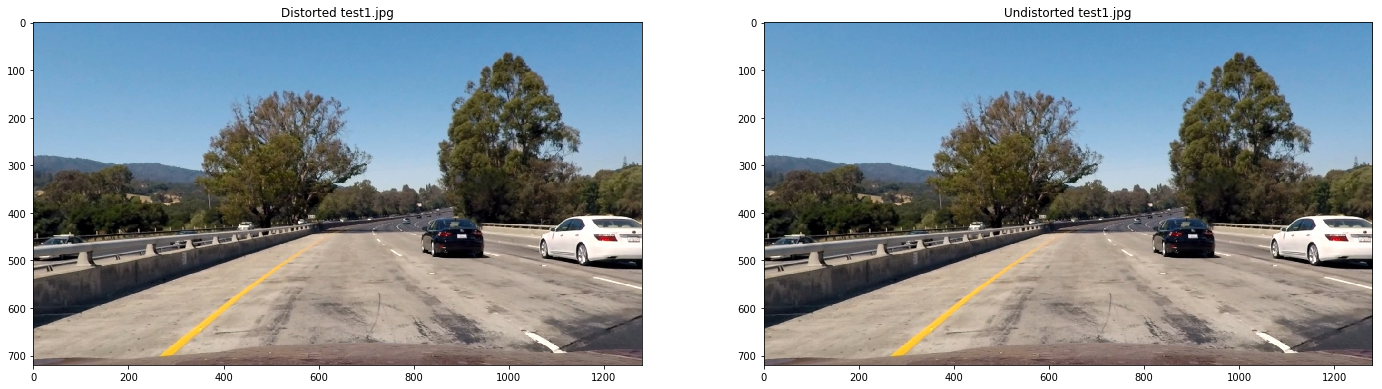

In [8]:
dist_img = cv2.imread('./test_images/test1.jpg')

undist = lane_detector.undistort(dist_img)
undist = cv2.cvtColor(undist, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(24,9))
plt.subplot(1, 2, 1)
plt.title('Distorted test1.jpg')
plt.imshow(undist)

plt.subplot(1, 2, 2)
plt.imshow(undist)
plt.title('Undistorted test1.jpg')

plt.show()

## Thresholding

(720, 1280)


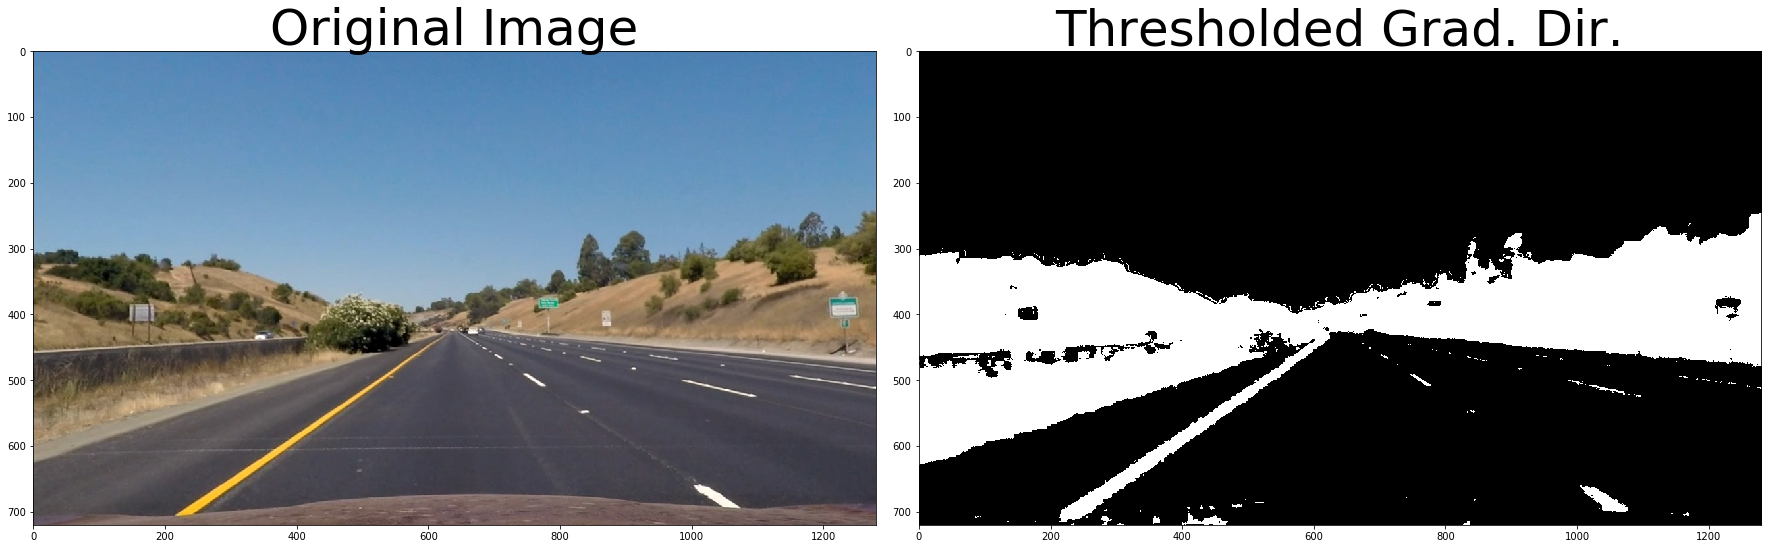

In [129]:
result = lane_detector.binary_image(undist)
print(result.shape)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(result, cmap='gray')
ax2.set_title('Thresholded image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Warp

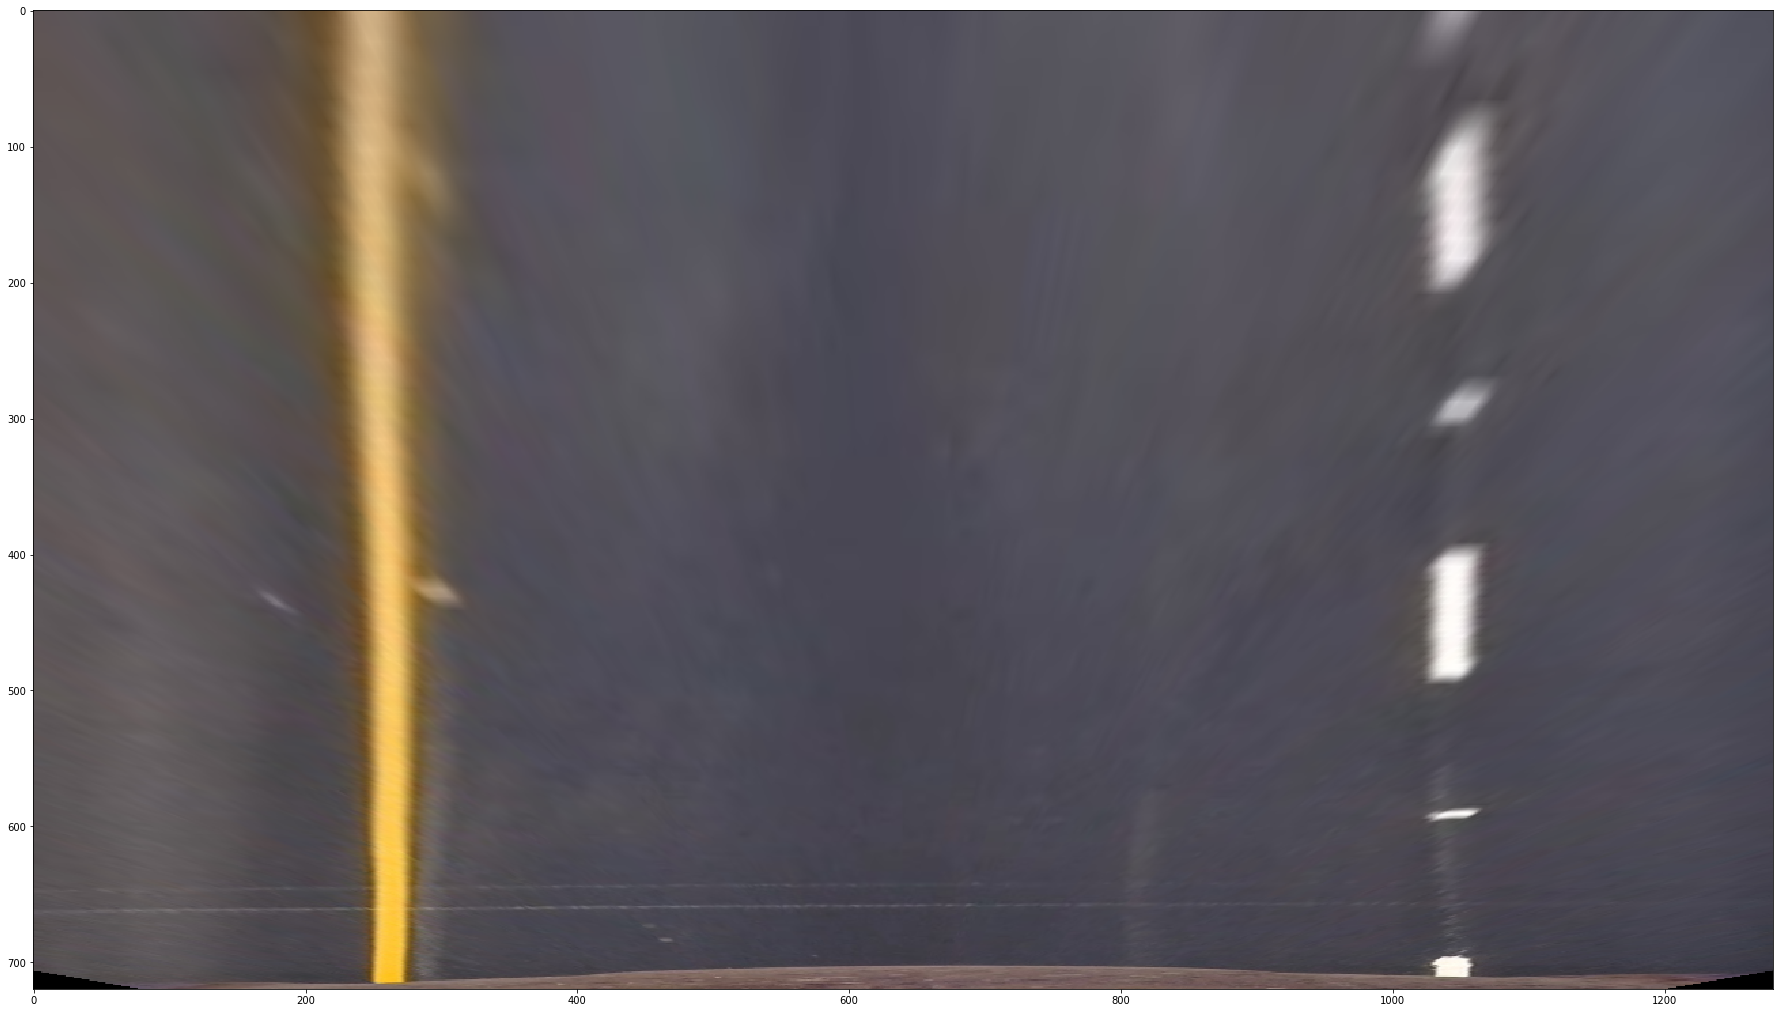

In [158]:
M, Minv = lane_detector.warp_matrices(undist)#
warped = lane_detector.warp_perspective(undist, M)
plt.figure(figsize = (48,18))
plt.imshow(warped)

In [186]:
## Histogram

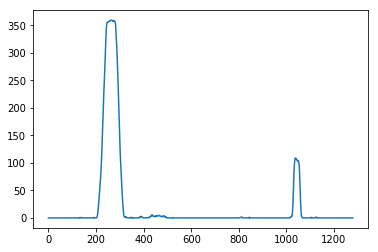

In [131]:
# Create histogram of image binary activations
histogram = lane_detector.hist(warped)

# Visualize the resulting histogram
plt.plot(histogram)

In [83]:
## Fit lane pixels

In [132]:
print('fitting polynomial to: ', warped.shape)
lane_detector.reset()
ploty, left_fitx, right_fitx, left_fit_cr, right_fit_cr, out_img = lane_detector.fit_polynomial(warped)

# TODO: WIP
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Start by generating our fake example data
# Make sure to feed in your real data instead in your project!
#ploty, left_fit_cr, right_fit_cr = generate_data(ym_per_pix, xm_per_pix)

# Define y-value where we want radius of curvature
# We'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)

# Calculation of R_curve (radius of curvature)
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

print(left_curverad, 'm', right_curverad, 'm')

#plt.imshow(warped)

fitting polynomial to:  (720, 1280)
208842.53132 m 55448.3100933 m


(720, 1280)


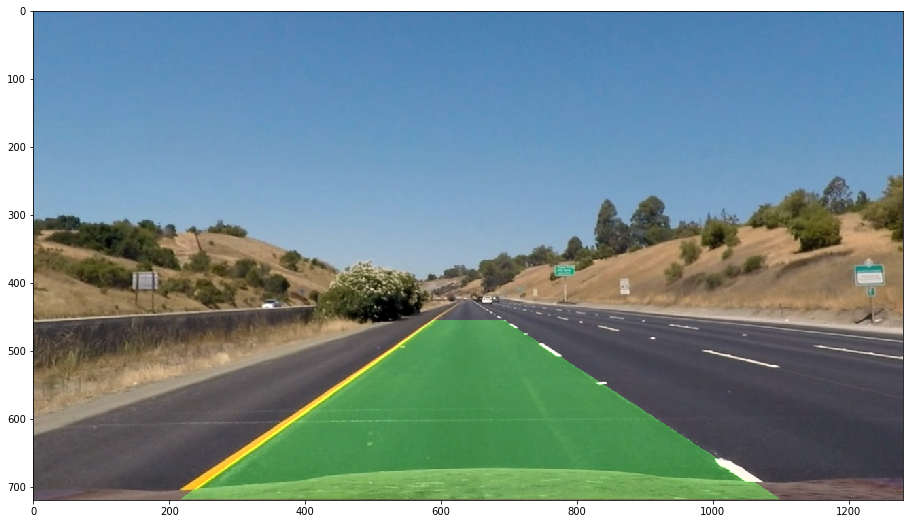

In [124]:
# Create an image to draw the lines on

def unwarp(image, binary_warped, ploty, left_fitx, right_fitx):
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    #print(color_warp.shape)
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    #print('img shape: ', image.shape, ' warp shape: ', newwarp.shape)
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    return result
print(warped.shape)

result = unwarp(undist, warped, ploty, left_fitx, right_fitx)
plt.figure(figsize = (24,9))
plt.imshow(result)

In [185]:
lane_detector.reset()
def process_image(image):
    image = lane_detector.undistort(image)
    image_original = image
    
    image = lane_detector.binary_image(image)
    
    M, Minv = lane_detector.warp_matrices(image)
    warped = lane_detector.warp_perspective(image, M)
    
    ploty, left_fitx, right_fitx, imagee = lane_detector.fit_lane_lines(warped)
    
    image = unwarp(image_original, warped, ploty, left_fitx, right_fitx)
    
    image = lane_detector.draw_lane_data(image, ploty)
        
    return image


output = 'project_video_processed.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_processed.mp4
[MoviePy] Writing video project_video_processed.mp4


 99%|█████████▉| 125/126 [00:36<00:00,  3.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_processed.mp4 

CPU times: user 42.9 s, sys: 4.48 s, total: 47.3 s
Wall time: 37.1 s
